In [1]:
from molecular_mpns.proto_molecule import Molecule
from molecular_mpns.config import data_dir,model_dir
from molecular_mpns.modules import ProtoNet
from molecular_mpns.data import MarkovMolGraph
import numpy as np
import torch
import mdtraj as md
import nglview as nv
import seaborn as sns

In [2]:
# molecular system
N = 5
beta = 15.0
kb = 1.0
rb = 2.0
ka = 1.0
ra = np.pi/2
kd = np.array([[0.02, 3], [0.02, 2]])
Mol = Molecule(N, beta, kb, rb, ka, ra, kd)

# load data
xyz_traj = np.load(str(data_dir)+'/proto_mol_traj.npy')
m = xyz_traj.shape[0]
traj = md.Trajectory(xyz_traj, Mol._create_top()) # create Trajectory object

# visulaize trajectory
view = nv.show_mdtraj(traj)
view.add_ball_and_stick(aspectRatio = 10)
view

NGLWidget(max_frame=2000000)

In [4]:
# simulate trajectory with model
np.random.seed(42)

dt = 5e-3
nsteps = 1
h = nsteps*dt

emb_dim = 128
intermediate_dim = 128
n_rbf = 128
rbf_range = [0.5,6]
gamma = 1

path = str(model_dir)+'/mod_proto_'+str(nsteps)+'.pt'
mod = ProtoNet(emb_dim,intermediate_dim,n_rbf,rbf_range,gamma)
mod.load_state_dict(torch.load(path))
mod = mod.eval()
mod = mod.double()

xyz_traj_sim = np.zeros((m,5,3))
xyz_traj_sim[0,:,:] = xyz_traj[0]
Z = np.array([[0],[0],[0],[0],[0]])

for t in range(1,m):
    xyz_current = xyz_traj_sim[t-1]
    g = MarkovMolGraph(r_current=xyz_current,r_next = xyz_current, Z = Z)
    V = mod(g)
    dV = torch.autograd.grad(V,g.r_current)[0]
    dV = dV.detach().cpu().numpy()
    xyz_next = xyz_current - dV*h + np.sqrt((2*h)/beta)*np.random.randn(5,3)
    xyz_traj_sim[t] = xyz_next
    

In [5]:

traj_sim = md.Trajectory(xyz_traj_sim, Mol._create_top()) # create Trajectory object

# visulaize trajectory
view_sim = nv.show_mdtraj(traj_sim)
view_sim.add_ball_and_stick(aspect_ratio = 10)
view_sim

NGLWidget(max_frame=2000000)

In [8]:
# compute distribution of simulated dihedral angles 

IC = np.zeros((m,2))

for i,xyz in enumerate(xyz_traj_sim):
    ic = Mol._internal_coordinates(xyz)
    da = ic[7:9]
    IC[i] = da

NameError: name 'plt' is not defined

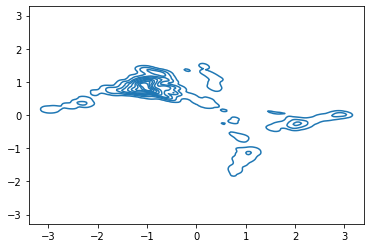

In [11]:
sns.kdeplot(x = IC[:,0],y = IC[:,1])
plt.show()
plt.close()